# Air Quality Time Series Analysis: Paris Region
    
This notebook demonstrates:
- Data loading from EEA parquet files 
- Data cleaning and validation 
- Time series analysis 
- Statistical analysis 
- Visualization with matplotlib 
 
**Data Source:** European Environment Agency (EEA)<br/>
**Location:** Paris region monitoring stations<br/>
**Period:** January 2022 - December 2022<br/>
**Pollutant:** O3 (Ozone)

## 1. Import Packages

In [531]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from scipy import stats

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Explore Available Cities

First, let's check what cities are available from the EEA API.

In [532]:
def get_available_cities(country_code, search_city=None, limit=10):
    """
    Get list of available cities from EEA API for a given country.
    
    Parameters:
    -----------
    country_code : str
        Two-letter country code (e.g., 'FR', 'ES', 'DE')
    search_city : str, optional
        City name to search for (e.g., 'Paris', 'Madrid')
    limit : int
        Number of sample cities to display (default: 10)
    
    Returns:
    --------
    list
        List of city dictionaries from the API
        
    Example:
    --------
    >>> cities = get_available_cities('ES', 'Madrid')
    >>> cities = get_available_cities('FR', 'Paris')
    """
    import requests
    
    city_api_url = "https://eeadmz1-downloads-api-appservice.azurewebsites.net/City"
    
    print(f"Fetching available cities from EEA API...")
    
    try:
        response = requests.post(city_api_url, json=[country_code], timeout=60)
        response.raise_for_status()
        
        cities = response.json()
        print(f"\n✓ Found {len(cities)} cities in {country_code}\n")
        
        # Show sample cities
        print(f"Sample cities:")
        for city in sorted(cities, key=lambda x: x['cityName'])[:limit]:
            print(f"  - {city['cityName']}")
        
        # Search for specific city if provided
        if search_city:
            matching_cities = [c for c in cities if search_city.lower() in c['cityName'].lower()]
            if matching_cities:
                print(f"\n✓ {search_city} found in city list:")
                for city in matching_cities:
                    print(f"  - {city}")
            else:
                print(f"\n⚠ {search_city} not found in city list")
                print(f"  This might mean the city filter doesn't work as expected")
        
        return cities
        
    except Exception as e:
        print(f"✗ Error: {e}")
        return []

In [533]:
# Search any cities available in Europe
eu_cities = get_available_cities('FR', 'Paris')

Fetching available cities from EEA API...

✓ Found 71 cities in FR

Sample cities:
  - Aix-en-Provence
  - Amiens
  - Angers
  - Annecy
  - Annemasse
  - Arras
  - Avignon
  - Bayonne
  - Belfort
  - Besançon

✓ Paris found in city list:
  - {'countryCode': 'FR', 'cityName': 'Paris (greater city)'}


In [534]:
import requests

def get_station_urls(country_code, city, pollutant="O3", dataset=1):
    """
    Get list of monitoring station URLs for a specific country, city, and pollutant.

    Parameters:
      - country_code: Two-letter code (e.g., 'FR', 'ES', 'DE')
      - city: City name (e.g., 'Paris', 'Madrid', 'Orléans') or None for all stations
      - pollutant: Pollutant code (default: 'O3')
      - dataset: 1=E2a (Up-To-Date), 2=E1a (Verified), 3=Historical
      """
    api_url = "https://eeadmz1-downloads-api-appservice.azurewebsites.net/"
    end_point = "ParquetFile/urls"

    request_body = {
        "countries": [country_code],
        "cities": [city] if city else [],
        "pollutants": [pollutant],
        "dataset": dataset
    }

    location = f"{city}, {country_code}" if city else country_code
    print(f"Fetching list of {pollutant} monitoring stations in {location}...")
    response = requests.post(api_url+end_point, json=request_body)

    if response.status_code == 200:
        urls = response.text.strip().split('\n')
        total_stations = len(urls) - 1  # -1 for header
        print(f"✓ Total {pollutant} stations: {total_stations}")

        if total_stations > 0:
            print(f"\nStation URLs (First 5):")
            for url in urls[1:6]:  # Skip header, show first 5
                print(f"  - {url}")
        else:
            print(f"\n⚠ No stations found for {location}!")
    else:
        print(f"✗ Error: {response.status_code}")

    return urls[1:] if response.status_code == 200 else []

In [535]:
get_station_urls("FR", "Paris (greater city)", "O3")

Fetching list of O3 monitoring stations in Paris (greater city), FR...
✓ Total O3 stations: 13

Station URLs (First 5):
  - https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04319_7.parquet
  - https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04055_7.parquet
  - https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04101_7.parquet
  - https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04049_7.parquet
  - https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04017_7.parquet


['https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04319_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04055_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04101_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04049_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04017_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04023_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04100_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04098_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04034_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airquality-p/FR/SPO-FR04149_7.parquet',
 'https://eeadmz1batchservice02.blob.core.windows.net/airqua

## 3. Download Function

In [536]:
import requests
from pathlib import Path
import zipfile

def download_eea_data(country_code, city, pollutant, start_date, end_date,
                        dataset=2, filename=None):
    """
    Download air quality data from EEA API.

    Parameters:
    -----------
    country_code : str
        Two-letter country code (e.g., 'FR', 'ES', 'NO')
    city : str
        City name (e.g., 'Paris (greater city)', 'Madrid')
    pollutant : str
        Pollutant notation (e.g., 'O3', 'NO2', 'PM2.5') or numeric code
    start_date : str
        Start date in ISO format (YYYY-MM-DDTHH:MM:SS.000Z)
    end_date : str
        End date in ISO format (YYYY-MM-DDTHH:MM:SS.000Z)
    dataset : int
        1 = E2a (Up-To-Date, unverified, 2023+)
        2 = E1a (Verified, 2013-2022)
        3 = Historical Airbase (2002-2012)
    filename : str, optional
        Custom name for the zip file (without .zip extension)
        If None, generates: {country}_{pollutant}_data.zip

    Returns:
    --------
    Path
        Path to extracted data directory
    """
    api_url = "https://eeadmz1-downloads-api-appservice.azurewebsites.net/"
    end_point = "ParquetFile"

    request_body = {
        "countries": [country_code],
        "cities": [city] if city else [],
        "pollutants": [pollutant],
        "dataset": dataset,
        "dateTimeStart": start_date,
        "dateTimeEnd": end_date
     }

    location = f"{city}, {country_code}" if city else country_code
    print(f"Downloading {pollutant} data for {location}...")
    print(f"Dataset type: {'E2a (Up-To-Date)' if dataset==1 else 'E1a (Verified)' if dataset==2 else 'Historical Airbase'}")
    print(f"Period: {start_date[:10]} to {end_date[:10]}")

    try:
        response = requests.post(api_url+end_point, json=request_body, timeout=300)
        response.raise_for_status()

        # Save and extract ZIP file
        data_dir = Path('data/raw')
        data_dir.mkdir(parents=True, exist_ok=True)

        # Use custom filename or generate default
        if filename:
            zip_filename = f"{filename}.zip"
            extract_folder = filename
        else:
            zip_filename = f"{country_code.lower()}_{pollutant.lower()}_data.zip"
            extract_folder = f"{country_code.lower()}_{pollutant.lower()}"

        zip_path = data_dir / zip_filename
        with open(zip_path, 'wb') as f:
            f.write(response.content)

        print(f"✓ Downloaded {len(response.content)/1024/1024:.1f} MB")
        print(f"✓ Saved as: {zip_filename}")

        # Extract ZIP file
        extract_path = data_dir / extract_folder
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        print(f"✓ Extracted to: {extract_path}")
        return extract_path

    except Exception as e:
        print(f"✗ Error downloading data: {e}")
        return None

In [537]:
# Download O3 data for Paris (full year 2022 - verified data available)
data_path = download_eea_data(
  country_code='FR',
  city='Paris (greater city)',
  pollutant='O3',
  start_date='2022-01-01T00:00:00.000Z',
  end_date='2022-12-31T23:59:59.000Z',
  dataset=2,  # E1a (Verified) - 2024 data not available yet
  filename='paris_o3_2022'
)

Dataset type: E1a (Verified)
Period: 2022-01-01 to 2022-12-31
✓ Downloaded 0.5 MB
✓ Saved as: paris_o3_2022.zip
✓ Extracted to: data/raw/paris_o3_2022


## 4. Data Loading and Cleaning

In [538]:
def load_data(data_path):
    """
    Load air quality data from parquet files.
    
    Parameters:
    -----------
    data_path : Path
        Path to directory containing parquet files
    
    Returns:
    --------
    pandas.DataFrame
        Loaded dataframe
    """
    # Find all parquet files
    parquet_files = list(Path(data_path).glob('**/*.parquet'))
    print(f"Found {len(parquet_files)} parquet file(s)")
    
    # Load all files
    dfs = []
    for file in parquet_files:
        df = pd.read_parquet(file)
        dfs.append(df)
    
    df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(df):,} raw measurements")
    
    return df

In [539]:
# Load Paris-O3 data from parquet files
df = load_data(data_path)
df.info()

Found 13 parquet file(s)
Loaded 113,843 raw measurements
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113843 entries, 0 to 113842
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Samplingpoint     113843 non-null  object        
 1   Pollutant         113843 non-null  int32         
 2   Start             113843 non-null  datetime64[ns]
 3   End               113843 non-null  datetime64[ns]
 4   Value             113843 non-null  object        
 5   Unit              113843 non-null  object        
 6   AggType           113843 non-null  object        
 7   Validity          113843 non-null  int32         
 8   Verification      113843 non-null  int32         
 9   ResultTime        113843 non-null  datetime64[ns]
 10  DataCapture       0 non-null       object        
 11  FkObservationLog  113843 non-null  object        
dtypes: datetime64[ns](3), int32(3), object(6)
memory usage: 9

In [540]:
def clean_data(df):   
    # Clean data
    original_count = len(df)
    
    # Convert to numeric and handle invalid values
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    df = df[df['Value'] > -999]  # Remove invalid measurements
    df = df.dropna(subset=['Value'])
    
    # Remove outliers (3 standard deviations)
    # z_scores = np.abs((df['Value'] - df['Value'].mean()) / df['Value'].std())
    # df = df[z_scores < 3]
    
    # Process datetime
    df['DateTime'] = pd.to_datetime(df['Start'])
    df['Date'] = df['DateTime'].dt.date
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek
    df['Month'] = df['DateTime'].dt.month
    
    # Sort by datetime
    df = df.sort_values('DateTime').reset_index(drop=True)
    
    removed = original_count - len(df)
    print(f"Cleaned: {len(df):,} measurements ({removed} removed, {removed/original_count*100:.1f}%)")
    
    return df

In [541]:
df = clean_data(df)
df.info()

Cleaned: 109,001 measurements (4842 removed, 4.3%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109001 entries, 0 to 109000
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Samplingpoint     109001 non-null  object        
 1   Pollutant         109001 non-null  int32         
 2   Start             109001 non-null  datetime64[ns]
 3   End               109001 non-null  datetime64[ns]
 4   Value             109001 non-null  float64       
 5   Unit              109001 non-null  object        
 6   AggType           109001 non-null  object        
 7   Validity          109001 non-null  int32         
 8   Verification      109001 non-null  int32         
 9   ResultTime        109001 non-null  datetime64[ns]
 10  DataCapture       0 non-null       object        
 11  FkObservationLog  109001 non-null  object        
 12  DateTime          109001 non-null  datetime64[ns]
 13  Date    

Understanding the EEA dataset columns and their meanings:

In [542]:
df.describe()

,Pollutant,Start,End,Value,Validity,Verification,ResultTime,DateTime,Hour,DayOfWeek,Month
count,109001.0,109001,109001,109001.000000,109001.0,109001.0,109001,109001,109001.000000,109001.000000,109001.000000
mean,7.0,2022-07-03 07:45:12.492545792,2022-07-03 08:45:12.492546048,50.046923,1.0,1.0,2023-09-08 11:21:32.599342848,2022-07-03 07:45:12.492545792,11.502060,3.007358,6.553490
min,7.0,2022-01-01 00:00:00,2022-01-01 01:00:00,0.000000,1.0,1.0,2022-09-07 19:29:41,2022-01-01 00:00:00,0.000000,0.000000,1.000000
25%,7.0,2022-03-30 22:00:00,2022-03-30 23:00:00,29.500000,1.0,1.0,2023-09-08 12:24:21,2022-03-30 22:00:00,5.000000,1.000000,3.000000
50%,7.0,2022-07-04 01:00:00,2022-07-04 02:00:00,49.800000,1.0,1.0,2023-09-08 12:24:21,2022-07-04 01:00:00,12.000000,3.000000,7.000000
75%,7.0,2022-10-05 07:00:00,2022-10-05 08:00:00,67.900000,1.0,1.0,2023-09-08 12:24:21,2022-10-05 07:00:00,18.000000,5.000000,10.000000
max,7.0,2022-12-31 22:00:00,2022-12-31 23:00:00,212.200000,1.0,1.0,2023-09-08 12:24:21,2022-12-31 22:00:00,23.000000,6.000000,12.000000
std,0.0,NaN,NaN,29.043770,0.0,0.0,NaN,NaN,6.927834,1.999555,3.497536


In [543]:
# Dataset shape and basic info
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1000:.2f} MB")
print(f"\nDate Range: {df['Start'].min()} to {df['Start'].max()}")
print(f"Time Span: {(df['Start'].max() - df['End'].min()).days} days")
print(f"\nNumber of Monitoring Stations: {df['Samplingpoint'].nunique()}")
print(f"Number of Measurements per Station: {df.groupby('Samplingpoint').size().describe().to_dict()}")

Dataset Shape: 109,001 rows × 17 columns

Memory Usage: 44.49 MB

Date Range: 2022-01-01 00:00:00 to 2022-12-31 22:00:00
Time Span: 364 days

Number of Monitoring Stations: 13
Number of Measurements per Station: {'count': 13.0, 'mean': 8384.692307692309, 'std': 748.9989301967643, 'min': 6468.0, '25%': 8611.0, '50%': 8681.0, '75%': 8734.0, 'max': 8747.0}


## Exploratory data analysis

### 5.1 Dataset Overview

Let's explore the structure and contents of our air quality dataset.

In [544]:
# Check for missing values (excluding optional fields)
print("MISSING VALUES:")
columns_to_check = [col for col in df.columns if col != 'DataCapture']
missing_df = pd.DataFrame({
  'Column': columns_to_check,
  'Missing Count': [df[col].isna().sum() for col in columns_to_check],
  'Missing %': [f"{(df[col].isna().sum() / len(df) * 100):.2f}%" for col in columns_to_check]
})
critical_missing = missing_df[missing_df['Missing Count'] > 0]
if len(critical_missing) > 0:
  print(critical_missing.to_string(index=False))
else:
  print("✓ No missing values")

MISSING VALUES:
✓ No missing values


In [545]:
# Check data validity
print("\nDATA VALIDITY:")
print(f"Valid measurements (Validity=1): {(df['Validity'] == 1).sum()} ({(df['Validity'] == 1).sum() / len(df) * 100:.1f}%)")
print(f"Verification status: {df['Verification'].value_counts().to_dict()}")

# Check for duplicates
print("\nDUPLICATES:")
duplicates = df.duplicated(subset=['Samplingpoint', 'DateTime']).sum()
print(f"Duplicate records (same station + time): {duplicates}")

# Value range check
print("\nVALUE RANGE:")
print(f"Minimum value: {df['Value'].min():.2f} µg/m³")
print(f"Maximum value: {df['Value'].max():.2f} µg/m³")
print(f"Mean ± Std: {df['Value'].mean():.2f} ± {df['Value'].std():.2f} µg/m³")


DATA VALIDITY:
Valid measurements (Validity=1): 109001 (100.0%)
Verification status: {1: 109001}

DUPLICATES:
Duplicate records (same station + time): 0

VALUE RANGE:
Minimum value: 0.00 µg/m³
Maximum value: 212.20 µg/m³
Mean ± Std: 50.05 ± 29.04 µg/m³


In [546]:
df.columns

Index(['Samplingpoint', 'Pollutant', 'Start', 'End', 'Value', 'Unit',
       'AggType', 'Validity', 'Verification', 'ResultTime', 'DataCapture',
       'FkObservationLog', 'DateTime', 'Date', 'Hour', 'DayOfWeek', 'Month'],
      dtype='object')

### 5.2 Monitoring Stations

In [547]:
df["Samplingpoint"].unique()

array(['FR/SPO-FR04049_7', 'FR/SPO-FR04029_7', 'FR/SPO-FR04100_7',
       'FR/SPO-FR04037_7', 'FR/SPO-FR04017_7', 'FR/SPO-FR04034_7',
       'FR/SPO-FR04023_7', 'FR/SPO-FR04101_7', 'FR/SPO-FR04055_7',
       'FR/SPO-FR04149_7', 'FR/SPO-FR04319_7', 'FR/SPO-FR04098_7',
       'FR/SPO-FR04004_7'], dtype=object)

In [548]:
def get_stations_info(samplingpoint_codes, country_name='France', json_path='data/raw/DataExtract.json'):
  """
  Load EEA station metadata and return information for given sampling points.

  Parameters:
  -----------
  samplingpoint_codes : str, list, or array-like
      Single code or list of codes like 'FR/SPO-FR04049_7'
  country_name : str
      Full country name (e.g., 'France', 'Spain'). Default: 'France'
  json_path : str
      Path to the metadata JSON file. Default: 'data/raw/DataExtract.json'

  Returns:
  --------
  pandas.DataFrame with station information
  """
  import json
  import pandas as pd

  # Handle single string input
  if isinstance(samplingpoint_codes, str):
      samplingpoint_codes = [samplingpoint_codes]

  # Load metadata
  print(f"Loading station metadata from {json_path}...")
  with open(json_path, 'r') as f:
      data = json.load(f)

  df_meta = pd.DataFrame(data)

  # Filter to relevant columns
  station_cols = [
      'Country', 'AirQualityStationEoICode', 'AirQualityStationNatCode',
      'AQStationName', 'AirPollutant', 'Longitude', 'Latitude', 'Altitude',
      'AirQualityStationArea', 'AirQualityStationType', 'Municipality'
  ]

  df_stations_meta = df_meta[station_cols].drop_duplicates(
      subset=['AirQualityStationEoICode', 'AirPollutant']
  )

  print(f"Loaded {len(df_stations_meta)} station-pollutant combinations")

  # Get info for each sampling point
  station_list = []
  for samplingpoint_code in samplingpoint_codes:
      # Extract station code: FR/SPO-FR04049_7 -> FR04049
      station_code = samplingpoint_code.split('SPO-')[1].split('_')[0]

      # Look up in metadata
      match = df_stations_meta[
          (df_stations_meta['Country'] == country_name) &
          (df_stations_meta['AirQualityStationNatCode'] == station_code)
      ]

      if len(match) > 0:
          info = match.iloc[0].to_dict()
          station_list.append({
              'Samplingpoint': samplingpoint_code,
              'StationName': info['AQStationName'],
              'Municipality': info['Municipality'],
              'StationType': info['AirQualityStationType'],
              'StationArea': info['AirQualityStationArea'],
              'Latitude': info['Latitude'],
              'Longitude': info['Longitude'],
              'Altitude': info['Altitude']
          })

  df_result = pd.DataFrame(station_list)
  print(f"Found {len(df_result)}/{len(samplingpoint_codes)} stations")

  return df_result

In [549]:
# Get info for all unique sampling points in your data
df_stations = get_stations_info(df["Samplingpoint"].unique(), country_name='France')
display(df_stations)

Loading station metadata from data/raw/DataExtract.json...
Loaded 57700 station-pollutant combinations
Found 13/13 stations


,Samplingpoint,StationName,Municipality,StationType,StationArea,Latitude,Longitude,Altitude
0,FR/SPO-FR04049_7,LES ULIS,LES ULIS,background,suburban,48.67944,2.16556,159.0
1,FR/SPO-FR04029_7,VERSAILLES,VERSAILLES,background,suburban,48.79917,2.13056,125.0
2,FR/SPO-FR04100_7,VILLEMOMBLE,VILLEMOMBLE,background,urban,48.88195,2.50722,85.0
3,FR/SPO-FR04037_7,PARIS 13eme,PARIS 13E ARRONDISSEMENT,background,urban,48.82861,2.36028,57.0
4,FR/SPO-FR04017_7,NEUILLY-SUR-SEINE,NEUILLY-SUR-SEINE,background,urban,48.88139,2.27806,36.0
5,FR/SPO-FR04034_7,VITRY-SUR-SEINE,VITRY-SUR-SEINE,background,urban,48.77590,2.37579,95.0
6,FR/SPO-FR04023_7,CERGY-PONTOISE,CERGY,background,urban,49.04639,2.04306,85.0
7,FR/SPO-FR04101_7,CHAMPIGNY-SUR-MARNE,CHAMPIGNY-SUR-MARNE,background,urban,48.81639,2.51750,74.0
8,FR/SPO-FR04055_7,PARIS 1er Les Halles,PARIS 1ER ARRONDISSEMENT,background,urban,48.86212,2.34462,35.0
9,FR/SPO-FR04149_7,MONTGERON,MONTGERON,background,urban,48.70670,2.45720,68.0


In [550]:
import folium

# Create interactive map centered on Paris
center_lat = df_stations['Latitude'].mean()
center_lon = df_stations['Longitude'].mean()

m = folium.Map(
    location=[center_lat, center_lon], 
    zoom_start=10,
    width='1200px',
    height='800px'
)

# Add markers for each station
for idx, row in df_stations.iterrows():
  color = 'red' if row['StationArea'] == 'urban' else 'blue'

  folium.CircleMarker(
      location=[row['Latitude'], row['Longitude']],
      radius=8,
      popup=f"<b>{row['StationName']}</b><br>"
            f"Municipality: {row['Municipality']}<br>"
            f"Type: {row['StationType']}<br>"
            f"Area: {row['StationArea']}<br>"
            f"Altitude: {row['Altitude']}m",
      color=color,
      fill=True,
      fillColor=color,
      fillOpacity=0.6
  ).add_to(m)

m

### 5.2 Basic Statistics

In [551]:
# Calculate statistics
stats_summary = {
    'Mean': df['Value'].mean(),
    'Median': df['Value'].median(),
    'Std Dev': df['Value'].std(),
    'Min': df['Value'].min(),
    'Max': df['Value'].max(),
    '25th Percentile': df['Value'].quantile(0.25),
    '75th Percentile': df['Value'].quantile(0.75),
    '95th Percentile': df['Value'].quantile(0.95)
}

print("\n=== O3 Concentration Statistics (µg/m³) ===")
for key, value in stats_summary.items():
    print(f"{key:20s}: {value:.2f}")

# WHO guideline for O3 (8-hour mean: 100 µg/m³)
who_guideline = 100
exceedances = (df['Value'] > who_guideline).sum()
exceedance_pct = (exceedances / len(df)) * 100
print(f"\nWHO Guideline Exceedances (>{who_guideline} µg/m³): {exceedances:,} ({exceedance_pct:.1f}%)")


=== O3 Concentration Statistics (µg/m³) ===
Mean                : 50.05
Median              : 49.80
Std Dev             : 29.04
Min                 : 0.00
Max                 : 212.20
25th Percentile     : 29.50
75th Percentile     : 67.90
95th Percentile     : 100.50

WHO Guideline Exceedances (>100 µg/m³): 5,590 (5.1%)


In [552]:
# Merge station info with measurements
df = df.merge(df_stations[['Samplingpoint', 'StationArea']], on='Samplingpoint', how='left')

# Calculate statistics by station area
print("\n=== O3 Concentration Statistics by Station Area (µg/m³) ===\n")

for area in df['StationArea'].unique():
  area_data = df[df['StationArea'] == area]['Value']

  print(f"{area.upper()} Stations:")
  print(f"  Count                : {len(area_data):,}")
  print(f"  Mean                 : {area_data.mean():.2f}")
  print(f"  Median               : {area_data.median():.2f}")
  print(f"  Std Dev              : {area_data.std():.2f}")
  print(f"  Min                  : {area_data.min():.2f}")
  print(f"  Max                  : {area_data.max():.2f}")
  print(f"  25th Percentile      : {area_data.quantile(0.25):.2f}")
  print(f"  75th Percentile      : {area_data.quantile(0.75):.2f}")
  print(f"  95th Percentile      : {area_data.quantile(0.95):.2f}")

  # WHO guideline exceedances
  who_guideline = 100
  exceedances = (area_data > who_guideline).sum()
  exceedance_pct = (exceedances / len(area_data)) * 100
  print(f"  WHO Exceedances (>{who_guideline}) : {exceedances:,} ({exceedance_pct:.1f}%)")
  print()

# Overall statistics (as before)
print("=== OVERALL Statistics ===")
stats_summary = {
  'Mean': df['Value'].mean(),
  'Median': df['Value'].median(),
  'Std Dev': df['Value'].std(),
  'Min': df['Value'].min(),
  'Max': df['Value'].max(),
  '25th Percentile': df['Value'].quantile(0.25),
  '75th Percentile': df['Value'].quantile(0.75),
  '95th Percentile': df['Value'].quantile(0.95)
}

for key, value in stats_summary.items():
  print(f"{key:20s}: {value:.2f}")

exceedances = (df['Value'] > who_guideline).sum()
exceedance_pct = (exceedances / len(df)) * 100
print(f"\nWHO Guideline Exceedances (>{who_guideline} µg/m³): {exceedances:,} ({exceedance_pct:.1f}%)")


=== O3 Concentration Statistics by Station Area (µg/m³) ===

SUBURBAN Stations:
  Count                : 24,393
  Mean                 : 51.18
  Median               : 51.20
  Std Dev              : 28.66
  Min                  : 0.00
  Max                  : 198.10
  25th Percentile      : 32.40
  75th Percentile      : 68.00
  95th Percentile      : 101.20
  WHO Exceedances (>100) : 1,298 (5.3%)

URBAN Stations:
  Count                : 84,608
  Mean                 : 49.72
  Median               : 49.40
  Std Dev              : 29.15
  Min                  : 0.00
  Max                  : 212.20
  25th Percentile      : 28.60
  75th Percentile      : 67.90
  95th Percentile      : 100.30
  WHO Exceedances (>100) : 4,292 (5.1%)

=== OVERALL Statistics ===
Mean                : 50.05
Median              : 49.80
Std Dev             : 29.04
Min                 : 0.00
Max                 : 212.20
25th Percentile     : 29.50
75th Percentile     : 67.90
95th Percentile     : 100.50

WHO Gu

### 5.3 Understanding EEA API Parameters

**Key Concepts:**

**1. Pollutant Codes:**
The `pollutants` parameter uses notation or numeric codes for different air pollutants.

**Ozone (O3)** - The focus of this analysis:
- **Notation**: `"O3"`
- **Numeric code**: `7`
- **Full URL**: `http://dd.eionet.europa.eu/vocabulary/aq/pollutant/7`

Other common pollutants for reference:
- SO2 (Sulfur Dioxide): `"SO2"` or `1`
- NO2 (Nitrogen Dioxide): `"NO2"` or `8`  
- PM10 (Particulate Matter < 10µm): `"PM10"` or `5`
- PM2.5 (Particulate Matter < 2.5µm): `"PM2.5"` or `6001`
- CO (Carbon Monoxide): `"CO"` or `10`
   
Complete pollutant vocabulary: https://dd.eionet.europa.eu/vocabulary/aq/pollutant

**2. Dataset Types:**
The `dataset` parameter specifies data verification level:
- `1` = **Up-To-Date/UTD/E2a** - Unverified data transmitted continuously from 2023 onwards (faster, preliminary)
- `2` = **Verified/E1a** - Official validated data from 2013-2022 reported annually (quality-controlled, delayed)
- `3` = **Historical Airbase** - Data delivered 2002-2012 before Air Quality Directive 2008/50/EC

In our data:
- `Pollutant` column = `7` → We're analyzing **Ozone (O3)**
- `dataset` parameter = `1` → Requesting **Up-To-Date data** (E2a)
- `Verification` column = `2` → Data is **verified** (quality-controlled)

More information: [Observation validity vocabulary](https://dd.eionet.europa.eu/vocabulary/aq/observationvalidity)

**3. Verification Levels:**
- `Verification = 1`: Unverified (preliminary)
- `Verification = 2`: Verified (quality-controlled)
- `Verification = 3`: Final verified data

**Reference**: [EEA API Documentation (April 2025)](https://eeadmz1-downloads-webapp.azurewebsites.net/content/documentation/How_To_Downloads.pdf) - Page 12

In [553]:
# Create data dictionary
data_dict = pd.DataFrame({
  'Column': df.columns,
  'Data Type': [str(df[col].dtype) for col in df.columns],
  'Non-Null Count': [df[col].count() for col in df.columns],
  'Description': [
      'Sampling point identifier (station code)',
      'Pollutant code (7 = O3/Ozone)',
      'Measurement start timestamp',
      'Measurement end timestamp',
      'Measured concentration value',
      'Unit of measurement (µg/m³)',
      'Aggregation type (hour, day, etc.)',
      'Data validity flag (1 = valid)',
      'Verification level (1 = unverified, 2 = verified)',
      'Timestamp when result was reported',
      'Data capture percentage',
      'Foreign key to observation log',
      'Parsed datetime (from Start)',
      'Extracted date',
      'Extracted hour (0-23)',
      'Day of week (0=Mon, 6=Sun)',
      'Month number (1-12)',
      'Station area type (urban/suburban)'  # Added this line
  ]
})

print("\n=== DATA DICTIONARY ===\n")
print(data_dict.to_string(index=False))


=== DATA DICTIONARY ===

          Column      Data Type  Non-Null Count                                       Description
   Samplingpoint         object          109001          Sampling point identifier (station code)
       Pollutant          int32          109001                     Pollutant code (7 = O3/Ozone)
           Start datetime64[ns]          109001                       Measurement start timestamp
             End datetime64[ns]          109001                         Measurement end timestamp
           Value        float64          109001                      Measured concentration value
            Unit         object          109001                       Unit of measurement (µg/m³)
         AggType         object          109001                Aggregation type (hour, day, etc.)
        Validity          int32          109001                    Data validity flag (1 = valid)
    Verification          int32          109001 Verification level (1 = unverified, 2 = veri

## 6. Visualizations

In [554]:
def plot_air_quality_analysis(df, station_area=None, figsize=(15, 10)):
  """
  Create comprehensive air quality visualization plots.

  Parameters:
  -----------
  df : DataFrame
      Air quality data with StationArea column
  station_area : str, optional
      Filter by 'urban' or 'suburban'. If None, plots both on same graphs.
  figsize : tuple
      Figure size (width, height)

  Returns:
  --------
  fig, axes : matplotlib figure and axes objects
  """
  # Create figure
  fig, axes = plt.subplots(2, 2, figsize=figsize)

  # Color scheme
  colors = {'urban': 'red', 'suburban': 'blue'}

  # Filter data if station_area specified
  if station_area:
      df_plot = df[df['StationArea'] == station_area]
      areas_to_plot = [station_area]
      title = f'Paris O3 Air Quality Analysis - {station_area.capitalize()} Stations (2022)'
  else:
      df_plot = df
      areas_to_plot = df['StationArea'].unique()
      title = 'Paris O3 Air Quality Analysis - Urban vs Suburban (2022)'

  fig.suptitle(title, fontsize=16, fontweight='bold')

  # WHO guideline
  who_guideline = 100

  # 1. Time series (daily average)
  for area in areas_to_plot:
      df_area = df_plot[df_plot['StationArea'] == area]
      daily_avg = df_area.groupby('Date')['Value'].mean()
      axes[0, 0].plot(daily_avg.index, daily_avg.values,
                      linewidth=1, alpha=0.7,
                      color=colors[area],
                      label=f'{area.capitalize()}: {df_area["Value"].mean():.1f} µg/m³')

  axes[0, 0].set_xlabel('Date')
  axes[0, 0].set_ylabel('O3 Concentration (µg/m³)')
  axes[0, 0].set_title('Daily Average Time Series')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # 2. Distribution
  for area in areas_to_plot:
      df_area = df_plot[df_plot['StationArea'] == area]
      axes[0, 1].hist(df_area['Value'], bins=50,
                      color=colors[area], alpha=0.3,
                      edgecolor='black',
                      label=f'{area.capitalize()}')

  axes[0, 1].axvline(who_guideline, color='black', linestyle='--',
                     linewidth=2, label=f'WHO: {who_guideline} µg/m³')
  axes[0, 1].set_xlabel('O3 Concentration (µg/m³)')
  axes[0, 1].set_ylabel('Frequency')
  axes[0, 1].set_title('Distribution of O3 Concentrations')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # 3. Hourly patterns
  for area in areas_to_plot:
      df_area = df_plot[df_plot['StationArea'] == area]
      hourly_avg = df_area.groupby('Hour')['Value'].agg(['mean', 'std']).reset_index()
      axes[1, 0].plot(hourly_avg['Hour'], hourly_avg['mean'],
                      marker='o', linewidth=2,
                      color=colors[area],
                      label=area.capitalize())
      axes[1, 0].fill_between(hourly_avg['Hour'],
                              hourly_avg['mean'] - hourly_avg['std'],
                              hourly_avg['mean'] + hourly_avg['std'],
                              alpha=0.10, color=colors[area])

  axes[1, 0].set_xlabel('Hour of Day')
  axes[1, 0].set_ylabel('O3 Concentration (µg/m³)')
  axes[1, 0].set_title('Daily Pattern (Mean ± Std Dev)')
  axes[1, 0].set_xticks(range(0, 24, 3))
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # 4. Weekly patterns
  day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

  if len(areas_to_plot) == 1:
      # Single area - full width bars
      area = areas_to_plot[0]
      df_area = df_plot[df_plot['StationArea'] == area]
      daily_avg = df_area.groupby('DayOfWeek')['Value'].agg(['mean', 'std']).reset_index()
      axes[1, 1].bar(daily_avg['DayOfWeek'], daily_avg['mean'],
                     color=colors[area], alpha=0.3,
                     edgecolor='black')
      axes[1, 1].errorbar(daily_avg['DayOfWeek'], daily_avg['mean'],
                          yerr=daily_avg['std'], fmt='none',
                          ecolor='black', capsize=5)
  else:
      # Multiple areas - side by side bars
      width = 0.35
      for i, area in enumerate(areas_to_plot):
          df_area = df_plot[df_plot['StationArea'] == area]
          daily_avg = df_area.groupby('DayOfWeek')['Value'].agg(['mean', 'std']).reset_index()
          offset = width * (i - 0.5)
          axes[1, 1].bar(daily_avg['DayOfWeek'] + offset, daily_avg['mean'],
                         width, color=colors[area], alpha=0.6,
                         edgecolor='black', label=area.capitalize())
          axes[1, 1].errorbar(daily_avg['DayOfWeek'] + offset, daily_avg['mean'],
                              yerr=daily_avg['std'], fmt='none',
                              ecolor='black', capsize=3)
      axes[1, 1].legend()

  axes[1, 1].set_xlabel('Day of Week')
  axes[1, 1].set_ylabel('O3 Concentration (µg/m³)')
  axes[1, 1].set_title('Weekly Pattern (Mean ± Std Dev)')
  axes[1, 1].set_xticks(range(7))
  axes[1, 1].set_xticklabels(day_names)
  axes[1, 1].grid(True, alpha=0.3, axis='y')

  plt.tight_layout()
  return fig, axes

(<Figure size 1500x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Daily Average Time Series'}, xlabel='Date', ylabel='O3 Concentration (µg/m³)'>,
         <Axes: title={'center': 'Distribution of O3 Concentrations'}, xlabel='O3 Concentration (µg/m³)', ylabel='Frequency'>],
        [<Axes: title={'center': 'Daily Pattern (Mean ± Std Dev)'}, xlabel='Hour of Day', ylabel='O3 Concentration (µg/m³)'>,
         <Axes: title={'center': 'Weekly Pattern (Mean ± Std Dev)'}, xlabel='Day of Week', ylabel='O3 Concentration (µg/m³)'>]],
       dtype=object))

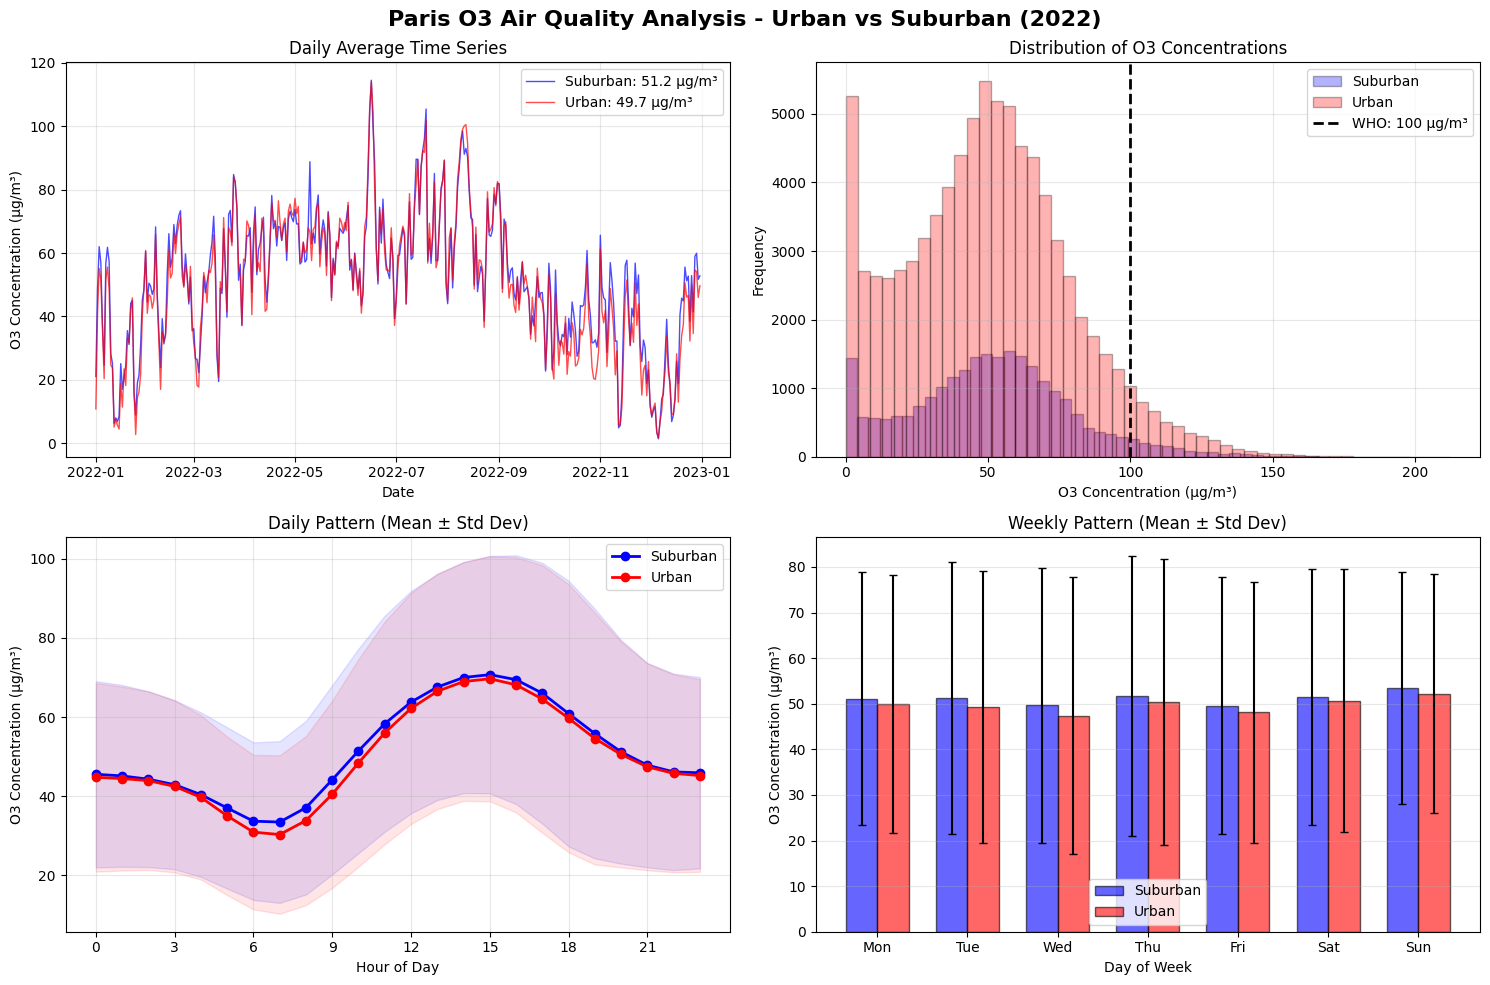

In [555]:
# Compare urban vs suburban on same plots
plot_air_quality_analysis(df)

In [559]:
# plot_air_quality_analysis(df, station_area='urban')

In [560]:
# plot_air_quality_analysis(df, figsize=(12, 8))

## 7. Key Findings

In [563]:
# Calculate hourly statistics for full dataset
hourly_avg = df.groupby('Hour')['Value'].agg(['mean', 'std']).reset_index()

# Find peak and minimum hours
peak_hour = hourly_avg.loc[hourly_avg['mean'].idxmax(), 'Hour']
min_hour = hourly_avg.loc[hourly_avg['mean'].idxmin(), 'Hour']
peak_value = hourly_avg['mean'].max()
min_value = hourly_avg['mean'].min()

print("\n=== KEY FINDINGS ===")
print(f"\n1. Data Coverage:")
print(f"   - Total measurements: {len(df):,}")
print(f"   - Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"   - Number of stations: {df['Samplingpoint'].nunique()}")
print(f"   - Number of days: {(df['Date'].max() - df['Date'].min()).days + 1}")

print(f"\n2. Daily Patterns:")
print(f"   - Peak hour: {int(peak_hour):02d}:00 ({peak_value:.1f} µg/m³)")
print(f"   - Minimum hour: {int(min_hour):02d}:00 ({min_value:.1f} µg/m³)")
print(f"   - Daily variation: {(peak_value - min_value):.1f} µg/m³")

weekday_avg = df[df['DayOfWeek'] < 5]['Value'].mean()
weekend_avg = df[df['DayOfWeek'] >= 5]['Value'].mean()
print(f"\n3. Weekly Patterns:")
print(f"   - Weekday average: {weekday_avg:.1f} µg/m³")
print(f"   - Weekend average: {weekend_avg:.1f} µg/m³")
print(f"   - Difference: {abs(weekday_avg - weekend_avg):.1f} µg/m³ ({((weekend_avg-weekday_avg)/weekday_avg*100):.1f}%)")

# Recalculate exceedances for current dataset
who_guideline = 100
exceedances = (df['Value'] > who_guideline).sum()
exceedance_pct = (exceedances / len(df)) * 100

print(f"\n4. Air Quality Assessment:")
print(f"   - Mean concentration: {df['Value'].mean():.1f} µg/m³")
print(f"   - Median concentration: {df['Value'].median():.1f} µg/m³")
print(f"   - WHO guideline (100 µg/m³) compliance: {100 - exceedance_pct:.1f}% of time")


=== KEY FINDINGS ===

1. Data Coverage:
   - Total measurements: 109,001
   - Date range: 2022-01-01 to 2022-12-31
   - Number of stations: 13
   - Number of days: 365

2. Daily Patterns:
   - Peak hour: 15:00 (69.9 µg/m³)
   - Minimum hour: 07:00 (31.0 µg/m³)
   - Daily variation: 38.9 µg/m³

3. Weekly Patterns:
   - Weekday average: 49.4 µg/m³
   - Weekend average: 51.7 µg/m³
   - Difference: 2.3 µg/m³ (4.6%)

4. Air Quality Assessment:
   - Mean concentration: 50.0 µg/m³
   - Median concentration: 49.8 µg/m³
   - WHO guideline (100 µg/m³) compliance: 94.9% of time


---

## Summary

This analysis demonstrates:
- ✓ Data acquisition from EEA API
- ✓ Data cleaning and validation (outlier removal)
- ✓ Time series analysis (trends, patterns)
- ✓ Statistical analysis (mean, percentiles, exceedances)
- ✓ Professional visualizations (matplotlib)

**Process analysis:** Python, pandas, data cleaning, time series analysis, matplotlib, API integration, statistical analysis

**Key Insights:**
- O3 shows strong diurnal pattern with peak in afternoon (photochemical production)
- Higher concentrations on weekends (less NO titration from traffic)
- Seasonal variation visible across 1-year period

---

## References

- [EEA Documentation - April 2025](https://eeadmz1-downloads-webapp.azurewebsites.net/content/documentation/How_To_Downloads.pdf)
- [Air quality download service API](https://eeadmz1-downloads-api-appservice.azurewebsites.net/swagger/index.html)